### **The CIR Stochastic Differential Equation (SDE)**
$$dr_t = a(b-r_t)dt + \sigma \sqrt{r_t}dW_t$$
Where:

- $r_t$ is the interest rate at time $t$
- $a$ is the speed of mean reversion
- $b$ is the long-term mean level of the interest rate
- $\sigma$ is the volatility of the interest rate
- $W_t$ is a standard Wiener process (Brownian motion)

### **Key Properties of the CIR Model**
1. **Mean Reversion**: The term $a(b - r_t)$ ensures that the interest rate tends to revert to the long-term mean $b$ over time.
2. **Non-Negativity**: The square root term $\sqrt{r_t}$ ensures that the interest rate remains non-negative, provided that the Feller condition $2ab \geq \sigma^2$ is satisfied.
3. **Volatility Structure**: The volatility of the interest rate is proportional to the square root of the current rate, meaning that volatility decreases as the interest rate approaches zero.

### **Applications of the CIR Model**
- **Interest Rate Modeling**: The CIR model is widely used to model the evolution of interest rates over time in financial markets.
- **Bond Pricing**: It is used to price interest rate derivatives and bonds, particularly those with embedded options.
- **Risk Management**: The model helps in assessing the risk associated with interest rate movements for financial institutions.

### **Solution to the CIR SDE**
The CIR model has a known closed-form solution for the transition density of $r_t$. The distribution of $r_t$ given $r_0$ is a non-central chi-squared distribution. Specifically, if $r_0$ is the initial interest rate, then:
$$r_t \sim \frac{\sigma^2(1 - e^{-at})}{4a} \chi^2_{d}(\lambda)$$

Where:
- $d = \frac{4ab}{\sigma^2} $ is the degrees of freedom
- $\lambda = \frac{4a e^{-at} r_0}{\sigma^2(1 - e^{-at})}$ is the non-centrality parameter

### **Parameter Estimation**
Parameters $a$, $b$, and $\sigma$ can be estimated using historical interest rate data through methods such as Maximum Likelihood Estimation (MLE) or the Generalized Method of Moments (GMM).

### **Numerical Simulation of the CIR Model**
To simulate paths of the CIR model, one can use the Euler-Maruyama method or more advanced techniques like the Milstein scheme. A simple Euler discretization is given by:
$$r_{t+\Delta t} = r_t + a(b - r_t)\Delta t + \sigma \sqrt{r_t} \sqrt{\Delta t} Z$$
Where $Z$ is a standard normal random variable.


### 0. **Load the Dataset**

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


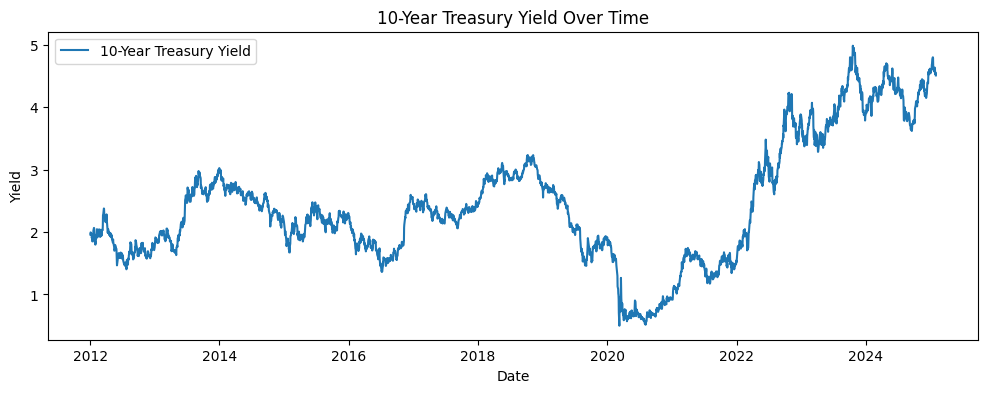

In [3]:
symbol = "^TNX"
start_date = "2012-01-01"
end_date = "2025-01-31"

data = yf.download(symbol, start=start_date, end=end_date)
data = data['Close'].dropna()

rate = data.values

plt.figure(figsize=(12,4))
plt.plot(data, label='10-Year Treasury Yield')
plt.title('10-Year Treasury Yield Over Time')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.show()

### **1. Estimates CIR parameters**
$$ r_{t+\Delta t} - r_t = a(b - r_t)\Delta t + \sigma \sqrt{r_t} \sqrt{\Delta t} \mathcal{N}(0,\Delta t) $$

$$\dfrac{r_{t+\Delta t} - r_t}{\sqrt{r_t}} = \dfrac{ab \Delta t}{\sqrt{r_t}}-a\sqrt{r_t} \Delta t + \sigma \sqrt{\Delta t} \mathcal{N}(0,1)$$

This can be write the linear regression:
$$y_i = \beta_1 z_{1,i} + \beta_2 z_{2,i}+ \epsilon_i$$
Where : 
$$\begin{aligned}
& y_i = \dfrac{r_{t+\Delta t} - r_t}{\sqrt{r_t}} \\
& \beta_1 = ab \\
& \beta_2 = -a \\
& z_{1,i} = \dfrac{\Delta t}{\sqrt{r_t}} \\
& z_{2,i} = \sqrt{r_t}\Delta t \\
& \epsilon_i = \sigma \sqrt{\Delta t} \mathcal{N}(0,1)
\end{aligned}$$

In [4]:
def ols_cir(rates, dt):
    """
    OLS calibration of CIR model:
    dr_t = a(b - r_t)dt + sigma sqrt(r_t) dW_t
    """

    rates = np.asarray(rates)

    # Keep only strictly positive rates
    mask = rates[:-1] > 0
    rs = rates[:-1][mask]
    rt = rates[1:][mask]

    # Dependent variable
    y = (rt - rs) / np.sqrt(rs)

    # Regressors
    z1 = dt / np.sqrt(rs)
    z2 = dt * np.sqrt(rs)
    X = np.column_stack((z1, z2))

    # OLS regression without intercept
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)

    beta1, beta2 = model.coef_

    # Recover CIR parameters
    a_hat = -beta2
    b_hat = beta1 / a_hat

    # Residuals and sigma
    residuals = y - model.predict(X)
    sigma_hat = np.std(residuals, ddof=1) / np.sqrt(dt)

    return a_hat, b_hat, sigma_hat

In [6]:
dt = 1/252
rates = rate/100
a, b, sigma = ols_cir(rates, dt)

print("Result of Estimation : ")
print(f"Mean reversion: a = ",a)
print(f"Long-term mean: b = ", b)
print(f"Volatility : sigma =",sigma)

Result of Estimation : 
Mean reversion: a =  0.32924807482277707
Long-term mean: b =  0.0302445410181786
Volatility : sigma = 0.05686958532836494


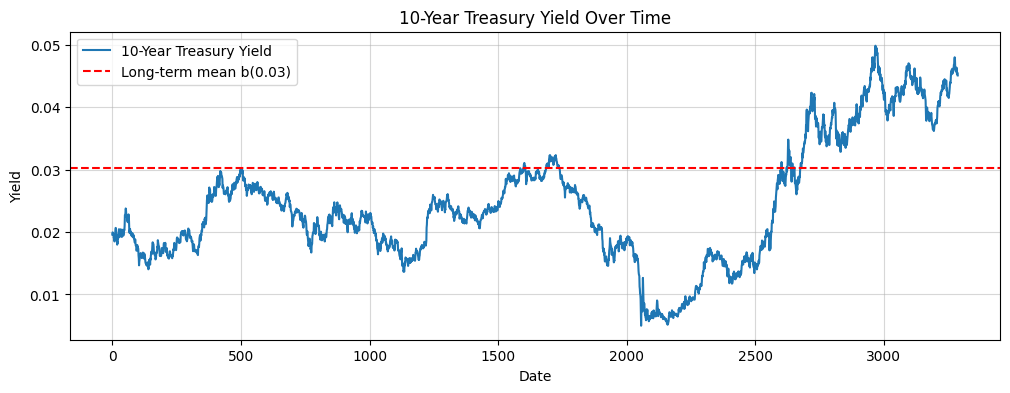

In [7]:
plt.figure(figsize=(12,4))
plt.plot(rate/100, label='10-Year Treasury Yield')
plt.axhline(y= b, linestyle='--',label = f'Long-term mean b({b:.2f})', color='r')
plt.title('10-Year Treasury Yield Over Time')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(alpha = 0.5)
plt.show()

### **Task 2: Simulation and Monte Carlo Pricing**


- **Discretize the SDE using the Euler-Maruyama method.**

    - Interval $[0,T]$ : step size $\Delta t = \frac{T}{N}$, where $N$ is the number of time steps.

    For the **CIR model**, the discretized form is:
    $$ r_{t+\Delta t} = r_t + a(b - r_t)\Delta t + \sigma \sqrt{r_t} \sqrt{\Delta t} Z $$
    Where $Z \sim N(0,1)$ is a standard normal random variable.

In [10]:
def simulate_cir_paths(r0, a, b, sigma, T, dt, n_paths):
    n_steps = int(T / dt)
    rates = np.zeros((n_steps + 1, n_paths))
    rates[0] = r0
    
    for t in range(1, n_steps + 1):
        # Standard Normal Random Variables
        dz = np.random.normal(0, np.sqrt(dt), n_paths)
        
        # CIR SDE: dr = a(b - r)dt + sigma * sqrt(r) * dW
        # We use np.maximum to ensure r doesn't go negative in the sqrt
        previous_r = rates[t-1]
        drift = a * (b - previous_r) * dt
        diffusion = sigma * np.sqrt(np.maximum(previous_r, 0)) * dz
        rates[t] = previous_r + drift + diffusion
        
    return rates


- **Calculate the bond price at maturity $T$ using the simulated interest rate paths.**

    The price of a zero-coupon bond at time $t$ maturing at time $T$ is given by:
    $$ P(t,T) = E_t\left[e^{-\int_t^T r_s ds}\right] $$

    Using Monte Carlo simulation, we can approximate this expectation by averaging over multiple simulated paths of the interest rate.
    
- **Estimate the bond price using Monte Carlo simulation.**
    1. Simulate multiple paths of the interest rate $r_t$ using the discretized CIR model.
    2. For each path, compute the integral $\int_0^T r_s ds$ using numerical integration (e.g., trapezoidal rule).
    3. Calculate the bond price for each path and average the results to get the estimated bond price:
    $$ \hat{P}(0,T) = \frac{1}{M} \sum_{i=1}^{M} e^{-\int_0^T r_s^{(i)} ds} $$
    Where $M$ is the number of simulated paths and $r_s^{(i)}$ is the interest rate path for the $i$-th simulation.
    

- **Calculate the Bond Price**
    - For each simulated path $i$, calculate the "Stochastic Discount Factor" (SDF):
    $$ D_i = \exp \left(-\sum_{j=1}^{M} r_j \Delta t \right) $$

    - The Monte Carlo price is the average of these factors across all $N$ paths:

    $$ P_{MC}(0,T) \approx \frac{1}{N} \sum_{i=1}^{N} D_i $$


In [8]:
def price_bond_mc(rates, dt):
    # Integral of r_t dt using the trapezoidal rule or simple sum
    integral_r = np.sum(rates[:-1], axis=0) * dt
    # Average of the discount factors
    return np.mean(np.exp(-integral_r))


In [11]:
# Parameters
# a = 0.2
# b = 0.05
# sigma = 0.03
r0 = rates[-1][0]
T_max = 10
dt = 1/252
n_steps = int(T_max / dt)
time_grid = np.linspace(0, T_max, n_steps + 1)
n_paths = 100
paths = simulate_cir_paths(r0, a, b, sigma, T_max, dt, n_paths)
mc_price = price_bond_mc(paths, dt)

print(f"Monte Carlo Bond Price (10Y): {mc_price:.4f}")

Monte Carlo Bond Price (10Y): 0.7090


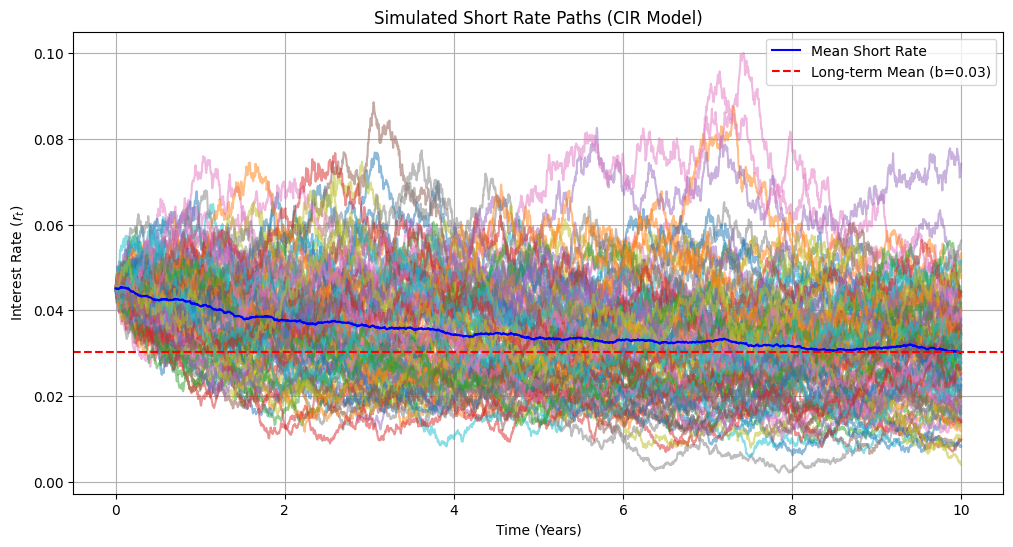

In [13]:
np.random.seed(42)
paths = simulate_cir_paths(r0, a, b, sigma, T_max, dt, n_paths)
mean_rates = np.mean(paths, axis=1)
plt.figure(figsize=(12, 6))
plt.plot(time_grid, paths ,alpha=0.5)
plt.plot(time_grid, mean_rates, label='Mean Short Rate', color='blue')
plt.axhline(y=b, color='r', linestyle='--', label=f'Long-term Mean (b={b:.2f})')
plt.title("Simulated Short Rate Paths (CIR Model)")
plt.xlabel("Time (Years)")
plt.ylabel("Interest Rate ($r_t$)")
plt.legend()
plt.grid(True)
plt.show()

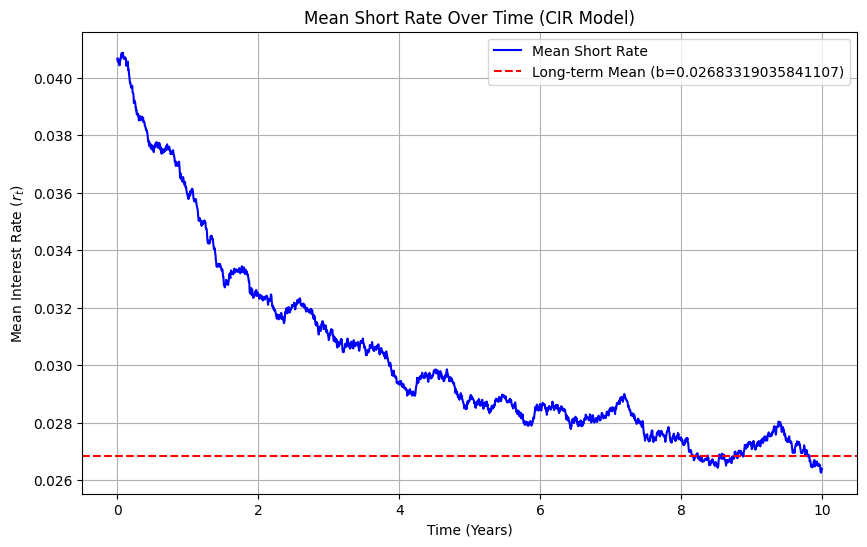

In [83]:
## Calculate the mean of interest rates at each time step
mean_rates = np.mean(paths, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(time_grid, mean_rates, label='Mean Short Rate', color='blue')
plt.axhline(y=b, color='r', linestyle='--', label=f'Long-term Mean (b={b})')
plt.title("Mean Short Rate Over Time (CIR Model)")
plt.xlabel("Time (Years)")
plt.ylabel("Mean Interest Rate ($r_t$)")
plt.legend()
plt.grid(True)
plt.show()

### **Task 3: Analytical Bond Pricing**


- The analytical bond price in the CIR model is given by:
$$ P(0,T) = A(T) e^{-B(T) r_0} $$
Where:
- We define a constant  $\gamma = \sqrt{a^2 + 2\sigma^2}$
- $$ A(T) = \left( \dfrac{2\gamma e^{(a+\gamma)T/2}}{(a+\gamma)(e^{\gamma T}-1) + 2\gamma} \right)^{\frac{2ab}{\sigma^2}} $$
- $$ B(T) = \dfrac{2(e^{\gamma T}-1)}{(a+\gamma)(e^{\gamma T}-1) + 2\gamma} $$

In [84]:
def cir_analytical_price(r0, a, b, sigma, T):
    if T == 0: return 1.0
    gamma = np.sqrt(a**2 + 2 * sigma**2)
    exp_g = np.exp(gamma * T)
    # calculate B(T)
    den_b = (gamma + a) * (exp_g - 1) + 2 * gamma
    B = 2 * (exp_g - 1) / den_b
    # calculate A(T)
    num_a = 2 * gamma * np.exp((a + gamma) * T / 2)
    A = (num_a / den_b)**(2 * a * b / sigma**2)

    return A * np.exp(-B * r0)


In [103]:
# Validation
mc_price = price_bond_mc(paths[:, :n_paths], dt)
analytical_price = cir_analytical_price(r0, a, b, sigma, T_max)
error = abs(mc_price - analytical_price)

print(f"Monte Carlo Price: {mc_price:.4f}")
print(f"Analytical Price: {analytical_price:.4f}")
print(f"Absolute Error: {error:.4f}")

Monte Carlo Price: 0.7459
Analytical Price: 0.7421
Absolute Error: 0.0038


**Comparison of Monte Carlo and Analytical Prices**

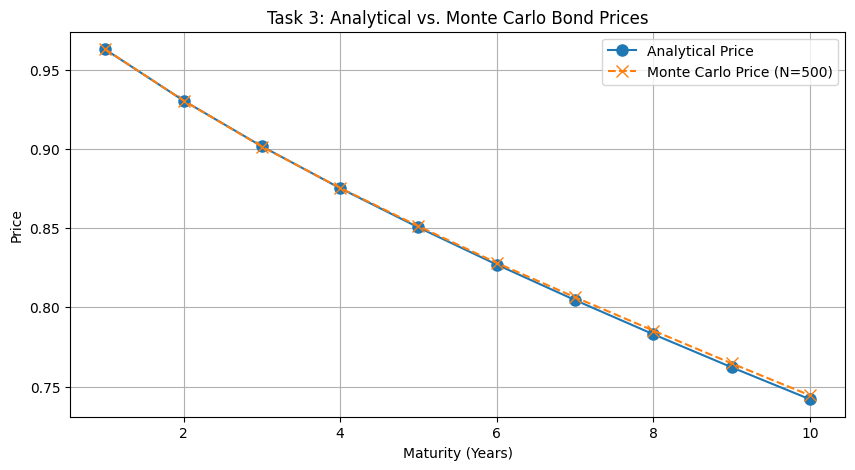

In [104]:
# Task 3: Compare Analytical vs Simulated Prices


r0 = rates[-1][0]
T_max = 10
dt = 1/252
n_steps = int(T_max / dt)
time_grid = np.linspace(0, T_max, n_steps + 1)
n_paths = 100

maturities = np.arange(1, 11)
analytical_prices = [cir_analytical_price(r0, a, b, sigma, T) for T in maturities]

# Monte Carlo with N=500
n_paths_mc = 500
full_paths = simulate_cir_paths(r0, a, b, sigma, 10, dt, n_paths_mc)
mc_prices = []
for T in maturities:
    steps_T = int(T / dt)
    integral_r = np.sum(full_paths[:steps_T, :], axis=0) * dt
    mc_prices.append(np.mean(np.exp(-integral_r)))

plt.figure(figsize=(10, 5))
plt.plot(maturities, analytical_prices, 'o-', label='Analytical Price', markersize=8)
plt.plot(maturities, mc_prices, 'x--', label=f'Monte Carlo Price (N={n_paths_mc})', markersize=8)
plt.title("Task 3: Analytical vs. Monte Carlo Bond Prices")
plt.xlabel("Maturity (Years)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

This plot compares the Zero-Coupon Bond prices calculated using the exact mathematical formula (Analytical) against the average of $500$ simulated paths (Monte Carlo).

- **Observations:** The Monte Carlo prices (marked with 'x') align almost perfectly with the analytical prices (the solid line). This confirms that your simulation logic is correct.

- **Trend:** As maturity increases, the bond price decreases. This is intuitive, as a dollar received 10 years from now is worth less today than a dollar received 1 year from now.

In [105]:
# Camparision dataframe
import pandas as pd

absolute_errors = [abs(ap - mp) for ap, mp in zip(analytical_prices, mc_prices)]

comparison_df = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Analytical Price': analytical_prices,
    f'Monte Carlo Price (N={n_paths_mc})': mc_prices,
    'Absolute Error': absolute_errors
})

comparison_df

,Maturity (Years),Analytical Price,Monte Carlo Price (N=500),Absolute Error
0,1,0.962651,0.962791,0.000140
1,2,0.930391,0.930399,0.000009
2,3,0.901567,0.901350,0.000218
3,4,0.875132,0.875351,0.000219
4,5,0.850418,0.851182,0.000764
5,6,0.827000,0.828049,0.001049
6,7,0.804604,0.806411,0.001806
7,8,0.783053,0.785369,0.002316
8,9,0.762229,0.764684,0.002456
9,10,0.742053,0.744529,0.002476


### **Task 4: Yield Curve and Parameter Analysis**

- **Yield Curve Generation**
    - Using the analytical bond pricing formula, generate the yield curve for different maturities $T$ by calculating the yield $ y(0,T) $:
    $$ y(0,T) = -\frac{1}{T} \ln(P(0,T)) $$

- **Parameter Sensitivity Analysis**
    - Analyze how changes in parameters $a$, $b$, and $\sigma$ affect the shape of the yield curve.
    - For example, increase/decrease each parameter by a certain percentage and observe the resulting changes in bond prices and yields.

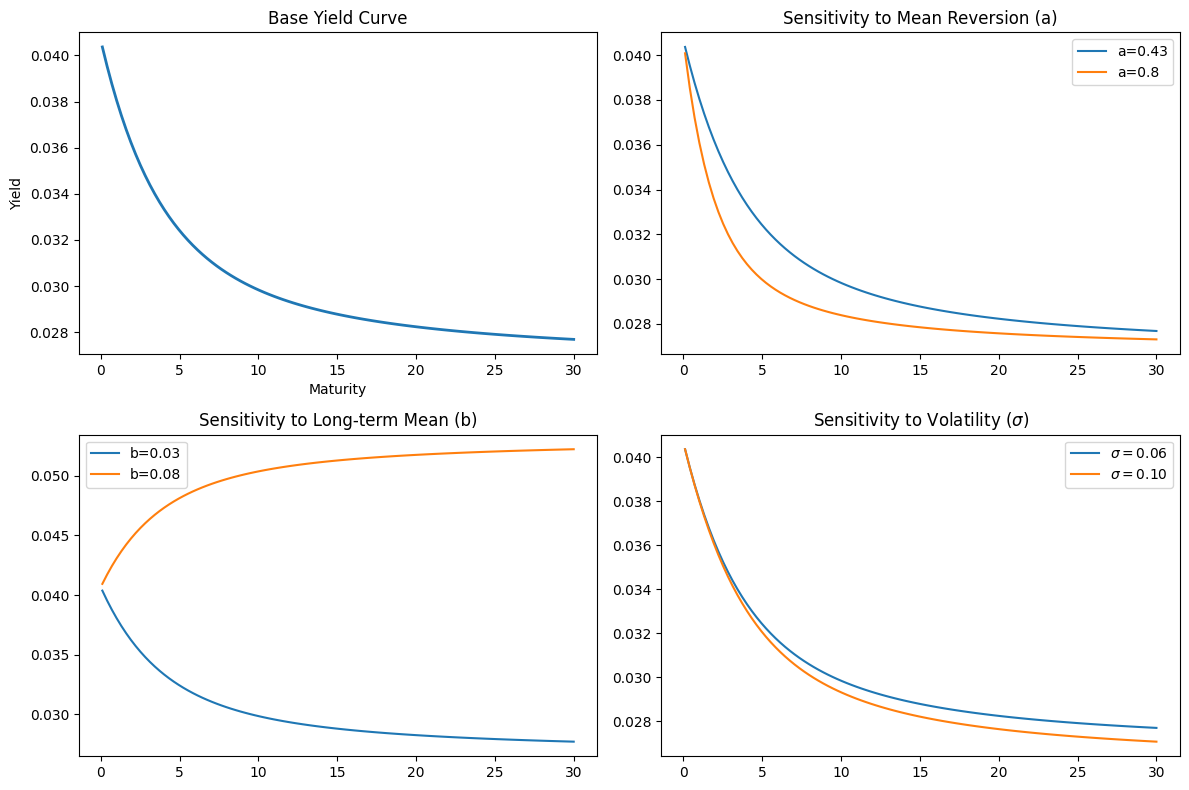

In [110]:
# Task 4: Yield Curve and Sensitivity
m_yields = np.linspace(0.1, 30, 100)
def get_yields(a, b, sigma):
    prices = [cir_analytical_price(r0, a, b, sigma, T) for T in m_yields]
    return -np.log(prices) / m_yields

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(m_yields, get_yields(a, b, sigma), label='Base Case', lw=2)
plt.title("Base Yield Curve")
plt.xlabel("Maturity")
plt.ylabel("Yield")

plt.subplot(2, 2, 2)
plt.plot(m_yields, get_yields(a, b, sigma), label=f'a={a:.2f}')
plt.plot(m_yields, get_yields(2*a, b, sigma), label='a=0.8')
plt.title("Sensitivity to Mean Reversion (a)")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(m_yields, get_yields(a, b, sigma), label=f'b={b:.2f}')
plt.plot(m_yields, get_yields(a, 2*b, sigma), label='b=0.08')
plt.title("Sensitivity to Long-term Mean (b)")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(m_yields, get_yields(a, b, sigma), label=f'$\sigma={sigma:.2f}$')
plt.plot(m_yields, get_yields(a, b, 2*sigma), label='$\sigma=0.10$')
plt.title("Sensitivity to Volatility ($\sigma$)")
plt.legend()

plt.tight_layout()
plt.show()

This dashboard shows how the term structure of interest rates changes when you manipulate the model's "knobs" ($a, b, \sigma$).

1. **Base Case:** A typical upward-sloping yield curve starting at $r_0 = 0.03$ and converging toward the mean.

2. **Sensitivity to $a$ (Speed):** A higher $a$ (0.8 vs 0.2) causes the curve to reach the long-term mean much faster, resulting in a steeper initial slope.

3. **Sensitivity to $b$ (Mean):** Increasing $b$ shifts the entire "long end" of the curve upward, as the market expects rates to be higher in the distant future.

4. **Sensitivity to $\sigma$ (Volatility):** Higher volatility actually creates a downward pressure on the yield curve for long maturities. This is due to "convexity bias" as uncertainty increases, the value of the bond's floor (it can't go below zero) becomes more valuable, raising the bond price and thus lowering the yield.